In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
#         print(os.path.join(dirname, filename))
        ...

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Goal: Classifying crack and non crack images.

## Context:
Concrete surface cracks are major defect in civil structures. 

Building Inspection which is done for the evaluation of rigidity and tensile strength of the building. 

Crack detection plays a major role in the building inspection, finding the cracks and determining the building health.

## Content:
The datasets contains images of various concrete surfaces with and without crack. The image data are divided into two as negative (without crack) and positive (with crack) in separate folder for image classification. 

Each class has 20000images with a total of 40000 images with 227 x 227 pixels with RGB channels. The dataset is generated from 458 high-resolution images (4032x3024 pixel) with the method proposed by Zhang et al (2016). 

High resolution images found out to have high variance in terms of surface finish and illumination condition. No data augmentation in terms of random rotation or flipping or tilting is applied.

# Import packages

In [4]:
import numpy as np
import os, pathlib
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.utils import image_dataset_from_directory

# Data Flow Preparation

The flow is as follows:

    1. positive_dir needs label 1 as 'positive' (using pandas df)
    2. negative_dir needs label 0 as 'negative' (using pandas df)
    3. combine both positive and negative images to total_images (using pandas df)
    4. split total_images to train, validation, and test dataset
    5. then do:
        - rescaling,
        - 

In [5]:
# Turn the directory paths into Path Obj
data_dir = '/kaggle/input/surface-crack-detection'
positive_dir = pathlib.Path('/kaggle/input/surface-crack-detection/Positive')
negative_dir = pathlib.Path('/kaggle/input/surface-crack-detection/Negative')

# Image count
positive_image_count = len(list(positive_dir.glob(r'*.jpg')))
negative_image_count = len(list(negative_dir.glob(r'*.jpg')))

print(f'Positive image count: {positive_image_count}')
print(f'Negative image count: {negative_image_count}')

Positive image count: 20000
Negative image count: 20000


## Display images in each directory

4th Image:  Image with crack


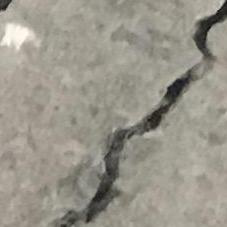

In [6]:
def show_img(show_crack=True, n=0):
    if show_crack:
        sub_folder = 'Positive'
        description = 'Image with crack'
    else:
        sub_folder = 'Negative'
        description = 'Image without crack'
    
    output_img = list(pathlib.Path(data_dir).glob(f'./{sub_folder}/*.jpg'))
    print(f'{n}th Image: ', description)
    return PIL.Image.open(str(output_img[n]))

show_img(n=4)

4th Image:  Image without crack


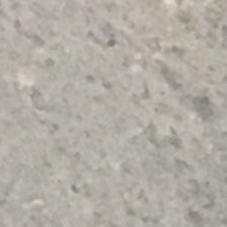

In [7]:
show_img(False, n=4)

In [8]:
# write a function to generate pd.DataFrame
def generate_df(image_dir, label):
    filepath = pd.Series(list(image_dir.glob(r'*jpg')), name='FilePath', dtype='string')
    labels = pd.Series(label, name='Label', index=filepath.index, dtype='string')
    df = pd.concat([filepath, labels], axis=1)
    return df

In [9]:
positive_df = generate_df(positive_dir, label=1)
negative_df = generate_df(negative_dir, label=0)
total_df = pd.concat([positive_df, negative_df], axis=0).reset_index(drop=True)
total_df.head()

,FilePath,Label
0,/kaggle/input/surface-crack-detection/Positive...,1
1,/kaggle/input/surface-crack-detection/Positive...,1
2,/kaggle/input/surface-crack-detection/Positive...,1
3,/kaggle/input/surface-crack-detection/Positive...,1
4,/kaggle/input/surface-crack-detection/Positive...,1


## Use Keras utility

`tf.keras.utils.image_dataset_from_directory`

In [10]:
data_dir = '/kaggle/input/surface-crack-detection'

***Define some parameters for the loader***

In [11]:
batch_size = 32
img_height, img_width = 120, 120

#### Split Train_ds, Val_ds using `tf.keras.utils.image_dataset_from_directory`

***train_ds***

In [12]:
seed_train_validation = 123
shuffle_value = True
validation_split = 0.3

In [13]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=validation_split,
    subset='training',
    seed=seed_train_validation,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 40000 files belonging to 2 classes.
Using 28000 files for training.


In [14]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

***See what's in train_ds***

`.take(1)` to look at the first batch only

In [15]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 120, 120, 3)
(32,)


***val_ds***

In [16]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=validation_split,
    subset='validation',
    seed=seed_train_validation,
    image_size=(img_height, img_width),
    batch_size=batch_size
)


Found 40000 files belonging to 2 classes.
Using 12000 files for validation.


In [17]:
type(val_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

***test_ds***

further split test_ds and val_ds from `val_ds`

In [18]:
val_batches = tf.data.experimental.cardinality(val_ds)

test_ds = val_ds.take((2 * val_batches) // 3) # take (2/3 of 30% total -> 20% of total data )
val_ds = val_ds.skip((2* val_batches) // 3)

In [19]:
tf.data.experimental.cardinality(test_ds)

<tf.Tensor: shape=(), dtype=int64, numpy=250>

In [20]:
tf.data.experimental.cardinality(train_ds)

<tf.Tensor: shape=(), dtype=int64, numpy=875>

In [21]:
tf.data.experimental.cardinality(val_ds)

<tf.Tensor: shape=(), dtype=int64, numpy=125>

***class_names***

In [22]:
class_names = train_ds.class_names
print(class_names)

['Negative', 'Positive']


### Visualize the data

***Here are the first nine images from the training datset***

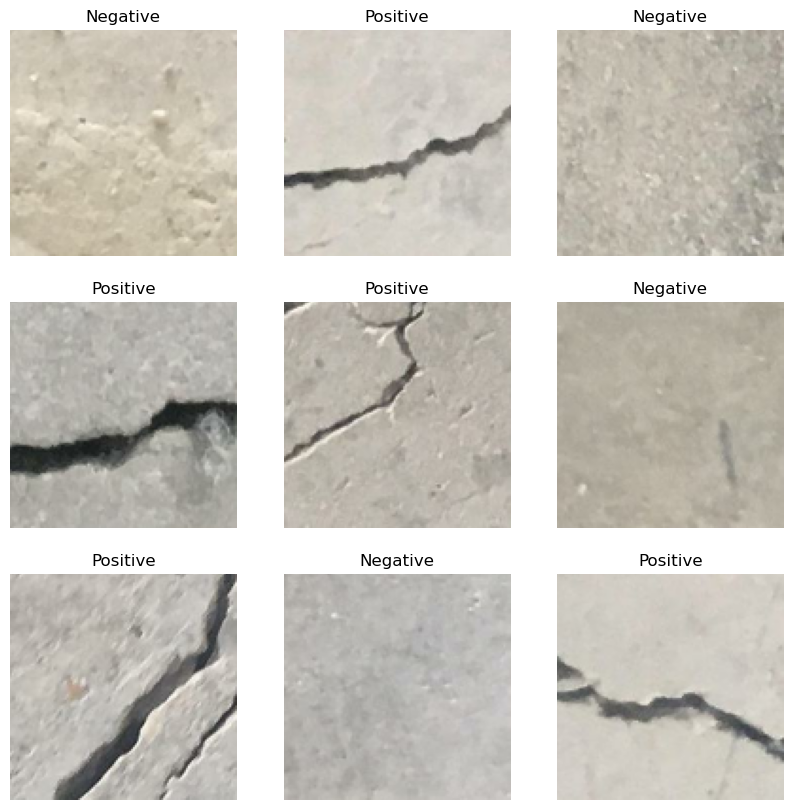

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    """take(1) == first batch has 32 images, but we only show the first 9"""
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

#### Visualize the data

***Here are the first nine images from the validation datset***

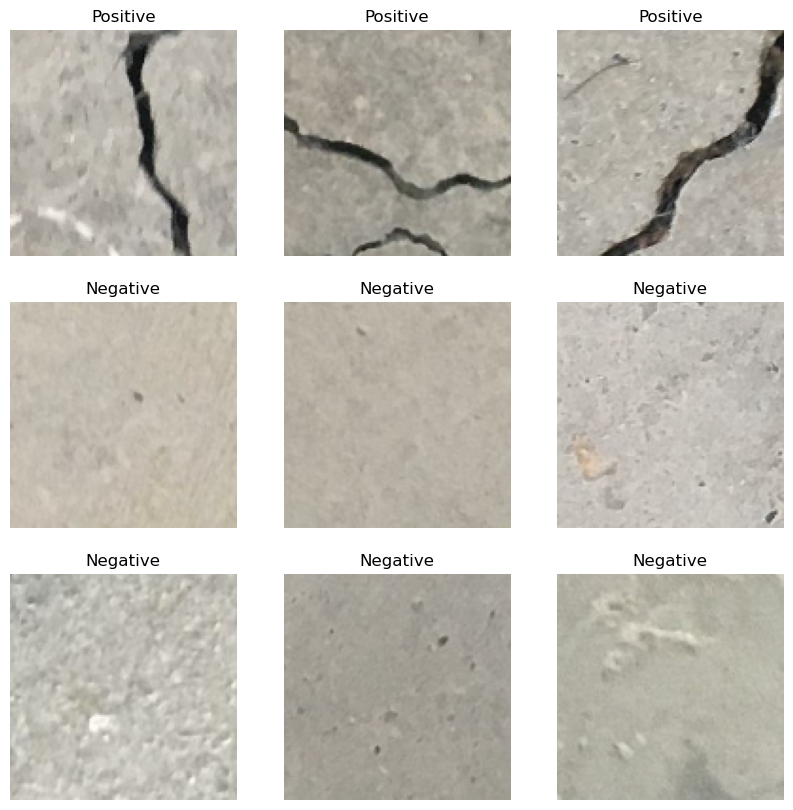

In [24]:
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
    """take(1) == first batch has 32 images, but we only show the first 9"""
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

### Configure the dataset for performance

`Dataset.cache` 
keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch` overlaps data preprocessing and model execution while training.

In [25]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### At this point, we have split train_ds, val_ds, test_ds 

---
The RGB channel values are in the [0, 255] range. 

This is not ideal for a neural network.
We should standardize values to be in the [0, 1] range. We will include the this layer inside the model definition


## 1. First Try - without Data Augmentation

1. build model
    - include Rescaling (pg.8-21)

2. compile

3. train



### 1) Build a simple CNN model

In [35]:
from tensorflow import keras
from tensorflow.keras import layers

# add batchnorml
# add dropout

inputs = keras.Input(shape=(120, 120, 3))
x = layers.Rescaling(1./ 255)(inputs) # rescale to [0, 1]
x = layers.Conv2D(filters=16, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
# x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
# x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
# x = layers.MaxPooling2D(pool_size=2)(x)
# x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
# x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.GlobalAveragePooling2D()(x)
# x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.Flatten()(x)
outputs = layers.Dense(units=1, activation='sigmoid')(x)
model = keras.Model(inputs=inputs, outputs=outputs, name='SimpleCNN')

model.summary()

Model: "SimpleCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 120, 120, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 118, 118, 16)      448       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 59, 59, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 57, 57, 32)        4640      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                     

### 2)  callbacks

In [36]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='/kaggle/working/checkpoint_path.keras',
        monitor='val_loss',
        save_best_only=True
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=2
    )
]

### 3) Plotting tools

In [37]:
import matplotlib.pyplot as plt

def plot_loss_vs_epoch(training_loss, val_loss):
    '''Plot training_loss, val_loss vs. epochs'''
    epochs = range(1, len(training_loss)+1)
    plt.plot(epochs, training_loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()



def plot_accuracy_vs_epoch(training_accuracy, val_accuracy):
    '''Plot training_accuracy, val_accuracy vs. epochs'''
    epochs = range(1, len(training_accuracy)+1)
    plt.plot(epochs, training_accuracy, 'b-', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'r--', label='Validation accuracy')
    plt.title("Training and Validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("accuracy")
    plt.legend()
    plt.show()

### 4) compile and fit with Keras built-in functions 

In [38]:
epochs = 10

"""compile"""
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])

"""fit()"""
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=callbacks)

Epoch 1/10
875/875 [==============================] - 7s 7ms/step - loss: 0.4053 - accuracy: 0.8361 - val_loss: 0.1549 - val_accuracy: 0.9682
Epoch 2/10
875/875 [==============================] - 6s 7ms/step - loss: 0.1105 - accuracy: 0.9687 - val_loss: 0.1083 - val_accuracy: 0.9775
Epoch 3/10
875/875 [==============================] - 6s 7ms/step - loss: 0.0822 - accuracy: 0.9758 - val_loss: 0.1058 - val_accuracy: 0.9800
Epoch 4/10
875/875 [==============================] - 6s 7ms/step - loss: 0.0746 - accuracy: 0.9781 - val_loss: 0.0870 - val_accuracy: 0.9805
Epoch 5/10
875/875 [==============================] - 6s 7ms/step - loss: 0.0715 - accuracy: 0.9797 - val_loss: 0.0894 - val_accuracy: 0.9815
Epoch 6/10
875/875 [==============================] - 6s 7ms/step - loss: 0.0698 - accuracy: 0.9800 - val_loss: 0.0924 - val_accuracy: 0.9833
Epoch 7/10
875/875 [==============================] - 6s 7ms/step - loss: 0.0687 - accuracy: 0.9810 - val_loss: 0.0950 - val_accuracy: 0.9833
Epoch 

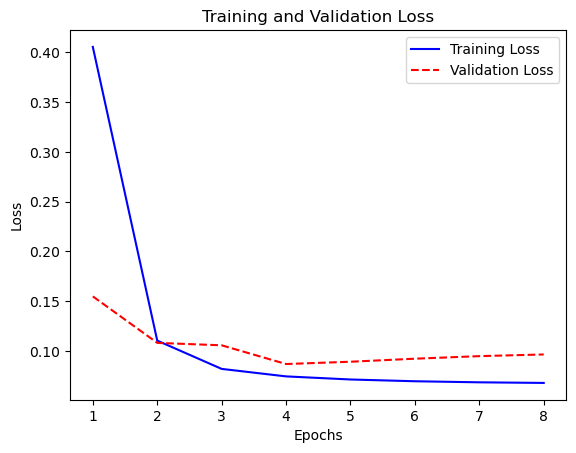

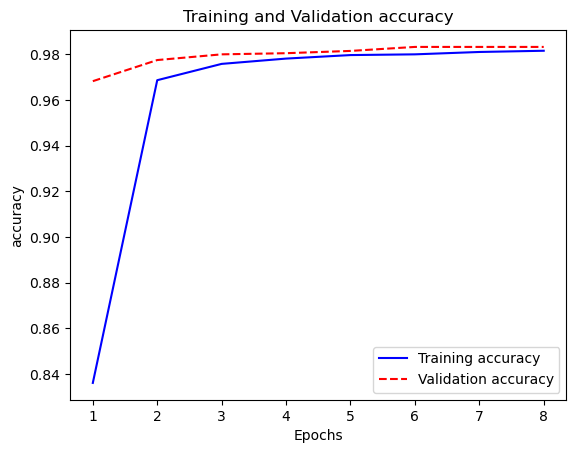

In [39]:
### For plotting
loss = history.history["loss"]
val_loss = history.history["val_loss"]
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

plot_loss_vs_epoch(loss, val_loss)
plot_accuracy_vs_epoch(accuracy, val_accuracy)

In [40]:
history_df = pd.DataFrame(history.history)
history_df

,loss,accuracy,val_loss,val_accuracy
0,0.405308,0.836107,0.154931,0.96825
1,0.110542,0.968679,0.108277,0.97750
2,0.082155,0.975821,0.105830,0.98000
3,0.074633,0.978143,0.087047,0.98050
4,0.071529,0.979679,0.089353,0.98150
5,0.069758,0.980000,0.092390,0.98325
6,0.068689,0.981036,0.094962,0.98325
7,0.068082,0.981571,0.096652,0.98325


### Evaluate with test dataset

In [56]:
test_loss, test_acc = model.evaluate(test_ds)

print("    Test Loss: {:.5f}".format(test_loss))
print("Test Accuracy: {:.2f}%".format(test_acc * 100))

250/250 [==============================] - 7s 26ms/step - loss: 0.0545 - accuracy: 0.9846
    Test Loss: 0.05446
Test Accuracy: 98.46%


## 2. Add in - Data Augmentation

In [57]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1), 
    layers.RandomZoom(0.2) 
])

### Lets see the results

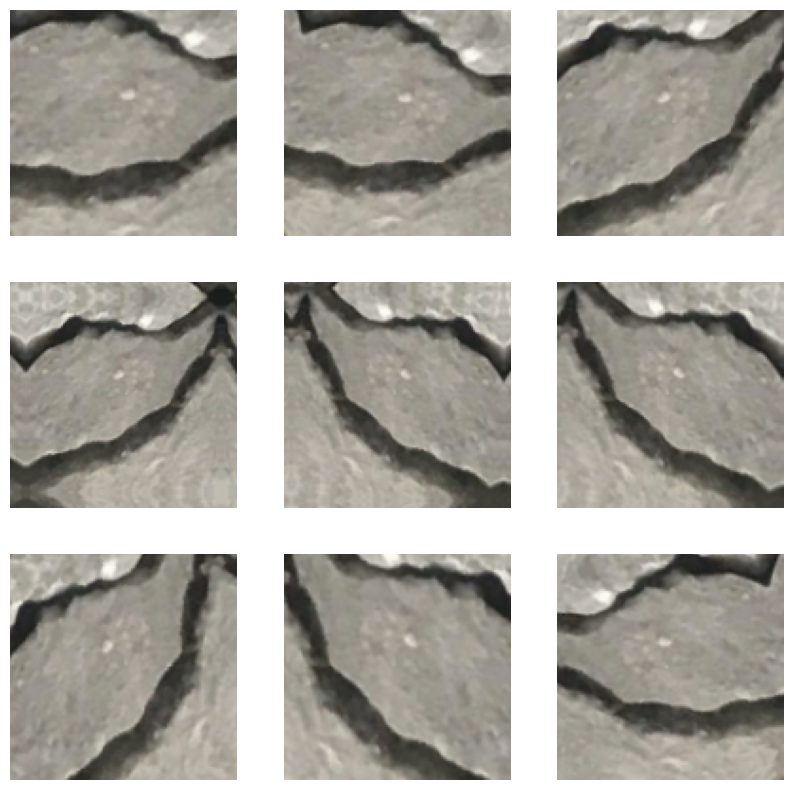

In [60]:
plt.figure(figsize=(10, 10))

for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis('off')

### Add this into the model

In [61]:
"""Model with Data Augmentation"""
inputs = keras.Input(shape=(120, 120, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./ 255)(x) # rescale to [0, 1]
x = layers.Conv2D(filters=16, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
# x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
# x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
# x = layers.MaxPooling2D(pool_size=2)(x)
# x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
# x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.GlobalAveragePooling2D()(x)
# x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.Flatten()(x)
outputs = layers.Dense(units=1, activation='sigmoid')(x)
model = keras.Model(inputs=inputs, outputs=outputs, name='SimpleCNN_Augmentation')

model.summary()

Model: "SimpleCNN_Augmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 120, 120, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 120, 120, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 118, 118, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 59, 59, 16)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 57, 57, 32)        4640      
                                            

In [62]:
epochs = 10

"""compile"""
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])

"""fit()"""
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=callbacks)

Epoch 1/10
875/875 [==============================] - 25s 27ms/step - loss: 0.4404 - accuracy: 0.8117 - val_loss: 0.2043 - val_accuracy: 0.9595
Epoch 2/10
875/875 [==============================] - 24s 27ms/step - loss: 0.1281 - accuracy: 0.9640 - val_loss: 0.2493 - val_accuracy: 0.9617
Epoch 3/10
875/875 [==============================] - 24s 27ms/step - loss: 0.0890 - accuracy: 0.9751 - val_loss: 0.2163 - val_accuracy: 0.9707
Epoch 4/10
875/875 [==============================] - 23s 27ms/step - loss: 0.0795 - accuracy: 0.9791 - val_loss: 0.3311 - val_accuracy: 0.9620
Epoch 5/10
875/875 [==============================] - 24s 27ms/step - loss: 0.0758 - accuracy: 0.9804 - val_loss: 0.5668 - val_accuracy: 0.9455


### Plot the results

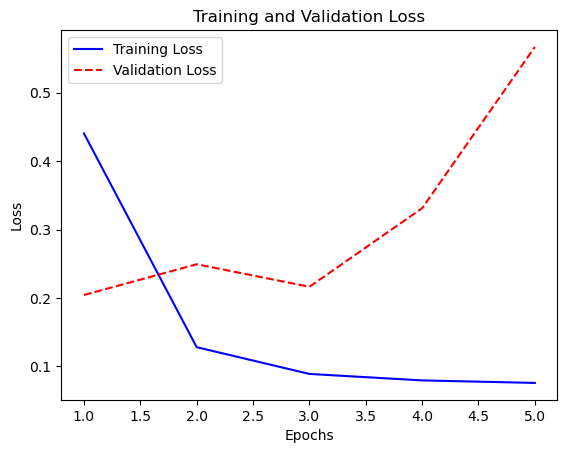

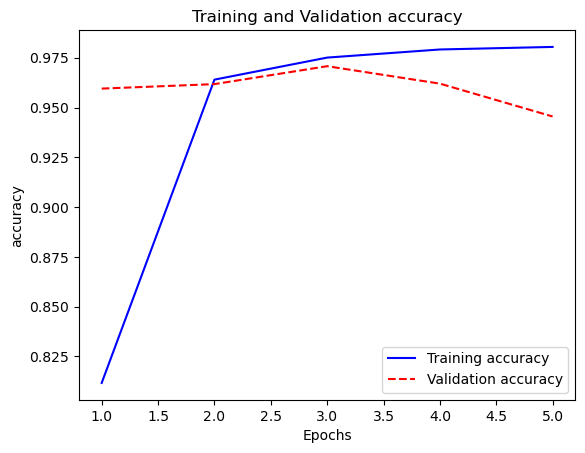

,loss,accuracy,val_loss,val_accuracy
0,0.440378,0.811714,0.204300,0.95950
1,0.128070,0.964000,0.249277,0.96175
2,0.088985,0.975071,0.216300,0.97075
3,0.079527,0.979143,0.331105,0.96200
4,0.075845,0.980429,0.566782,0.94550


In [63]:
### For plotting
loss = history.history["loss"]
val_loss = history.history["val_loss"]
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

plot_loss_vs_epoch(loss, val_loss)
plot_accuracy_vs_epoch(accuracy, val_accuracy)

history_df = pd.DataFrame(history.history)
history_df

### Evaluate with test_ds

In [64]:
test_loss, test_acc = model.evaluate(test_ds)

print("    Test Loss: {:.5f}".format(test_loss))
print("Test Accuracy: {:.2f}%".format(test_acc * 100))

250/250 [==============================] - 7s 25ms/step - loss: 0.4815 - accuracy: 0.9414
    Test Loss: 0.48149
Test Accuracy: 94.14%


## 3. Implement BatchNormalization along with Data Augmentation

In [70]:
"""Model with BatchNormalization and Data Augmentation"""
inputs = keras.Input(shape=(120, 120, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./ 255)(x) # rescale to [0, 1]
x = layers.Conv2D(filters=16, kernel_size=3, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
# x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
# x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
# x = layers.MaxPooling2D(pool_size=2)(x)
# x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
# x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.GlobalAveragePooling2D()(x)
# x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.Flatten()(x)
outputs = layers.Dense(units=1, activation='sigmoid')(x)
model = keras.Model(inputs=inputs, outputs=outputs, name='SimpleCNN_Aug_BN')

model.summary()

Model: "SimpleCNN_Aug_BN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 120, 120, 3)       0         
                                                                 
 rescaling_7 (Rescaling)     (None, 120, 120, 3)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 118, 118, 16)      432       
                                                                 
 batch_normalization_4 (Batc  (None, 118, 118, 16)     64        
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 118, 118, 16)      0         
                                                  

In [71]:
epochs = 10

"""compile"""
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])

"""fit()"""
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=callbacks)

Epoch 1/10
875/875 [==============================] - 26s 29ms/step - loss: 0.2186 - accuracy: 0.9375 - val_loss: 0.1762 - val_accuracy: 0.9300
Epoch 2/10
875/875 [==============================] - 26s 29ms/step - loss: 0.0865 - accuracy: 0.9762 - val_loss: 1.1022 - val_accuracy: 0.6975
Epoch 3/10
875/875 [==============================] - 26s 30ms/step - loss: 0.0592 - accuracy: 0.9834 - val_loss: 0.8030 - val_accuracy: 0.8940


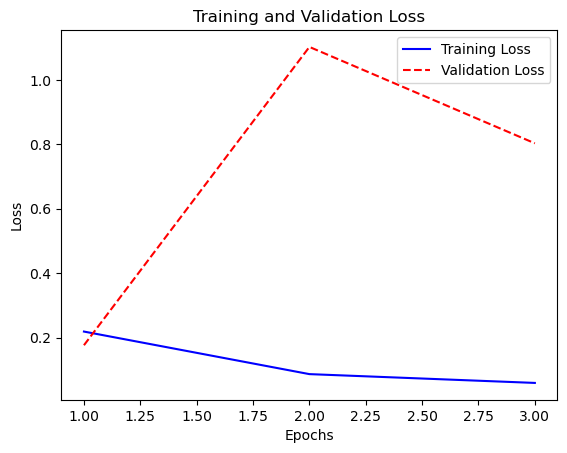

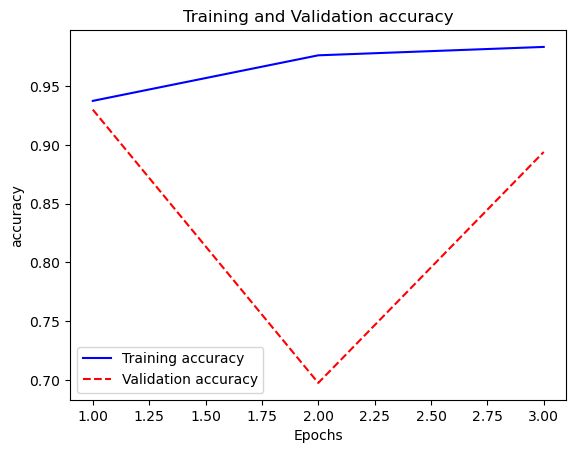

,loss,accuracy,val_loss,val_accuracy
0,0.218648,0.937464,0.176201,0.9300
1,0.086527,0.976214,1.102192,0.6975
2,0.059210,0.983357,0.803012,0.8940


In [72]:
### For plotting
loss = history.history["loss"]
val_loss = history.history["val_loss"]
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

plot_loss_vs_epoch(loss, val_loss)
plot_accuracy_vs_epoch(accuracy, val_accuracy)

history_df = pd.DataFrame(history.history)
history_df

In [73]:
test_loss, test_acc = model.evaluate(test_ds)

print("    Test Loss: {:.5f}".format(test_loss))
print("Test Accuracy: {:.2f}%".format(test_acc * 100))

250/250 [==============================] - 6s 25ms/step - loss: 0.8049 - accuracy: 0.8956
    Test Loss: 0.80486
Test Accuracy: 89.56%


## 4. Use pre-trained models with Data Augmentation

---
to be continued

## 4. Conclusion/Findings